In [2]:
import pathlib
import os

import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_dir = '/content/drive/MyDrive/archive.zip'
import zipfile
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')

In [5]:
data_dir = pathlib.Path('/content/datasets/AMHCD_64/AMHCD_64')
print("Le répertoire de données : {} ".format(data_dir))

Le répertoire de données : /content/datasets/AMHCD_64/AMHCD_64 


In [6]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import splitfolders
splitfolders.ratio(data_dir, output="output", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 25740 files [00:04, 5960.49 files/s]


In [8]:
#Taille des images
img_height = 32
img_width = 32

In [9]:
# train_data est un objet tensor, chaque élement est un tuple (image,label) 
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/output/train",
  image_size=(img_height, img_width),
  #batch_size=1,
  )


Found 20592 files belonging to 33 classes.


In [10]:
# val_data est un objet tensor, chaque élement est un tuple (image,label) 
val_data = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/output/val",
  image_size=(img_height, img_width),
  #batch_size=batch_size,
  )

Found 2574 files belonging to 33 classes.


In [11]:
# val_data est un objet tensor, chaque élement est un tuple (image,label) 
test_data = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/output/test",
  image_size=(img_height, img_width),
  #batch_size=batch_size,
  )

Found 2574 files belonging to 33 classes.


In [12]:
class_names = val_data.class_names
print("Les classes :")
print(class_names)
print("Nombre de classe : {} ".format(len(class_names)))

Les classes :
['ya', 'yab', 'yach', 'yad', 'yadd', 'yae', 'yaf', 'yag', 'yagh', 'yagw', 'yah', 'yahh', 'yaj', 'yak', 'yakw', 'yal', 'yam', 'yan', 'yaq', 'yar', 'yarr', 'yas', 'yass', 'yat', 'yatt', 'yaw', 'yax', 'yay', 'yaz', 'yazz', 'yey', 'yi', 'yu']
Nombre de classe : 33 


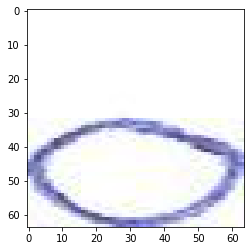

In [13]:
#Exemple d'une image
image = plt.imread("/content/output/val/ya/ya_121.jpeg")
plt.imshow(image)

In [14]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import keras_tuner
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers, losses
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import MaxPool2D

In [34]:
"""
tuner = keras_tuner.BayesianOptimization(
                        hypermodel=MyHyperModel(),
                        objective = "val_accuracy",
                        max_trials =10, #max candidates to test
                        overwrite=True,
                        directory='BO_search_dir',
                        project_name='sign_language_cnn')
"""

'\ntuner = keras_tuner.BayesianOptimization(\n                        hypermodel=MyHyperModel(),\n                        objective = "val_accuracy",\n                        max_trials =10, #max candidates to test\n                        overwrite=True,\n                        directory=\'BO_search_dir\',\n                        project_name=\'sign_language_cnn\')\n'

In [16]:
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

def build_model(hp):
    #defining model
    model=Sequential()
    model.add(Rescaling(1./255))
    model.add(Conv2D(hp.Int('input_units',
                                min_value=32,
                                max_value=256,
                                step=32), (3, 3), padding="same", input_shape=(32, 32, 3),activation="relu"))
    
    # Number of Conv Layers is up to tuning
    for i in range( hp.Int("num_conv", min_value=1, max_value=5, step=1)) :
      model.add(Conv2D(hp.Int(f'conv_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), (3, 3),
                                padding='same',
                                activation='relu'))
      
      
      model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Dropout(0.5))
    model.add(Flatten())

    for i in range(hp.Int("num_dense", min_value=1, max_value=4, step=1)) :
       model.add(Dense(hp.Choice(f'n_nodes',
                                  values=[64,128, 256, 512, 1024]),activation="relu"))
       
       
    model.add(Dense(33,activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=0.001),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    return model

In [17]:
from kerastuner.tuners import RandomSearch
tuner = RandomSearch( build_model,
                      max_trials=5,  # how many model variations to test?
                      objective = "val_accuracy",
                      executions_per_trial=3,  # how many trials per variation? (same model could perform differently)
                      )

<ipython-input-17-c71820cb3b24>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [18]:
tuner.search(x=train_data, epochs=20,
             validation_data=val_data)

Trial 5 Complete [00h 49m 12s]
val_accuracy: 0.9892514745394388

Best val_accuracy So Far: 0.9935250083605448
Total elapsed time: 02h 29m 08s


In [19]:

from tensorflow.keras.utils import plot_model
# Get the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(1)[0]

# get the best model
best_model = tuner.get_best_models(1)[0]


In [23]:
print(tuner.get_best_hyperparameters()[0].values)

{'input_units': 160, 'num_conv': 4, 'conv_0_units': 256, 'num_dense': 1, 'n_nodes': 512, 'conv_1_units': 256, 'conv_2_units': 128, 'conv_3_units': 32}


In [24]:

nblocks = best_hps.get('num_conv')
print(f'Number of conv blocks: {nblocks}')


Number of conv blocks: 4


In [30]:

# Build the model with the optimal hyperparameters
# train the model.
model = tuner.hypermodel.build(best_hps)
historique = model.fit(train_data, 
          validation_data=val_data, 
          epochs= 40,)
           #callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])


Epoch 1/40


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


644/644 [==============================] - 15s 20ms/step - loss: 3.4026 - accuracy: 0.0559 - val_loss: 1.6669 - val_accuracy: 0.5105
Epoch 2/40
644/644 [==============================] - 13s 20ms/step - loss: 0.7442 - accuracy: 0.7609 - val_loss: 0.1705 - val_accuracy: 0.9549
Epoch 3/40
644/644 [==============================] - 13s 20ms/step - loss: 0.2635 - accuracy: 0.9193 - val_loss: 0.1607 - val_accuracy: 0.9608
Epoch 4/40
644/644 [==============================] - 13s 19ms/step - loss: 0.1778 - accuracy: 0.9468 - val_loss: 0.0732 - val_accuracy: 0.9786
Epoch 5/40
644/644 [==============================] - 13s 19ms/step - loss: 0.1492 - accuracy: 0.9564 - val_loss: 0.0851 - val_accuracy: 0.9763
Epoch 6/40
644/644 [==============================] - 13s 19ms/step - loss: 0.1226 - accuracy: 0.9647 - val_loss: 0.0670 - val_accuracy: 0.9837
Epoch 7/40
644/644 [==============================] - 13s 19ms/step - loss: 0.1365 - accuracy: 0.9682 - val_loss: 0.0634 - val_accuracy: 0.9895
Epo

In [36]:

# display model structure
# show model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 160)       4480      
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 256)       368896    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 256)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 256)       590080    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 8, 8, 256)        0         
 2D)                                                  

In [35]:
model.save('/content/drive/MyDrive/cnn_model(Random_searchVF).h5')


In [31]:
import pandas as pd
metrics = pd.DataFrame(historique.history)

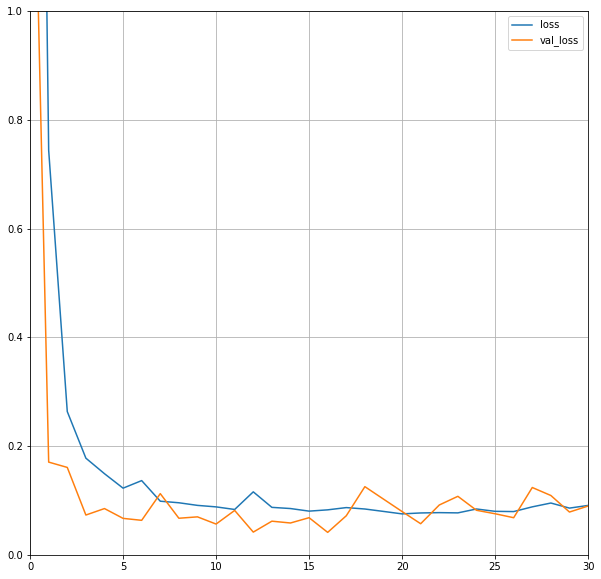

In [43]:
plt.figure(figsize=(10,10))
plt.ylim([0,1])
plt.xlim([0,30])
plt.plot(metrics[["loss"]],label = "loss")
plt.plot(metrics[["val_loss"]],label="val_loss")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

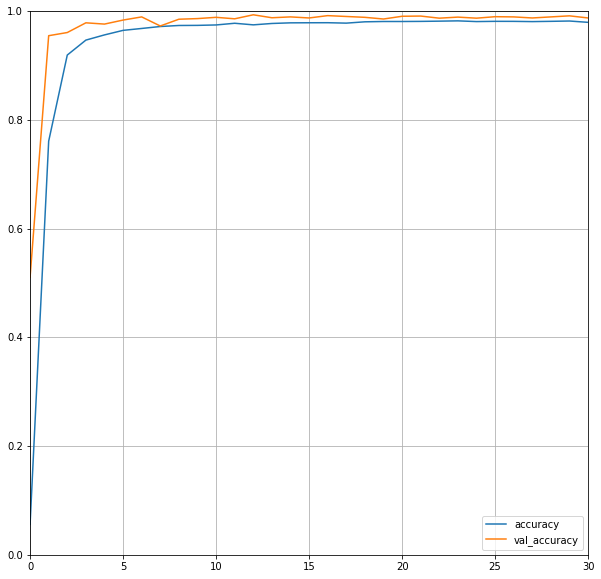

In [47]:
plt.figure(figsize=(10,10))
plt.ylim([0,1])
plt.xlim([0,30])
plt.plot(metrics[["accuracy"]],label = "accuracy")
plt.plot(metrics[["val_accuracy"]],label="val_accuracy")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [34]:
model.evaluate(test_data)

81/81 [==============================] - 2s 22ms/step - loss: 0.0708 - accuracy: 0.9942


[0.07083651423454285, 0.9941725134849548]